# Imports and Pytorch Settings

In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from collections import defaultdict
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

# Check Library Version Info and GPU Availability

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Python VERSION:', sys.version)
  print('pyTorch VERSION:', torch.__version__)
  print('Active CUDA Device: GPU', torch.cuda.current_device())
  print('Available devices: ', torch.cuda.device_count())
  print('Current CUDA device: ', torch.cuda.current_device())
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()

Python VERSION: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
pyTorch VERSION: 1.13.1+cu116
Active CUDA Device: GPU 0
Available devices:  1
Current CUDA device:  0
Wed Feb 22 00:26:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A

# Compute Loss Function

In [4]:
# calculate gradient with respect to any x and use this to form loss
def compute_gradient(u, x, num_u_vectors):
    
    # compute gradient of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dx for each u and combine them all together afterwards
        du_dx = torch.autograd.grad(u[:, i, :], x, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dx)

    deriv_to_x = torch.stack(derivs_list, dim=1)
    
    return deriv_to_x

# build the loss function
def loss(x, A_list, v_list, force, G_list, model):
    
    # dictionary to store loss results for plotting
    loss_dict = {} 
    # current loss
    L = 0

    # create the trial solution
    model_result = lambda x: model(x)[0]
    u_results = model_result(x)
   
    # determine the number of u vectors
    num_u_vectors = u_results['head 1'].shape[1]
    
    # loss will be the sum of the terms from the "multi-head" model, hence we iterate over each head's outputs
    for i, head_i in enumerate(u_results.keys()):
        # extract the u for the current "head", corresponding to one of the initial conditions
        u = u_results[head_i].unsqueeze(dim=-1)

        # compute matrix of partial derivatives
        D_u = compute_gradient(u, x, num_u_vectors) 

        # compute D_U * G.T
        D_u_times_G_T = torch.matmul(D_u, G_list[i].T)

        # compute (D_U * G.T) x I where x is the Hadamard product
        identity_mat = torch.eye(num_u_vectors, device=dev)
        D_u_times_G_t_x_I = torch.mul(D_u_times_G_T, identity_mat)

        # compute ((D_U * G.T) x I) * [1, 1....]
        ones_vec = torch.ones(num_u_vectors, device=dev).unsqueeze(dim=-1)
        D_u_times_G_t_x_I_times_ones = torch.matmul(D_u_times_G_t_x_I, ones_vec)

        # compute A * u 
        A_times_u = torch.matmul(A_list[i], u)

        # compute the L_t term 
        L_t_term = D_u_times_G_t_x_I_times_ones + A_times_u - torch.stack([force] * len(x))
        L_t = torch.matmul(L_t_term.mT, L_t_term)

        # extract u_0 from the model (BOUNDARY CONDITION DEPENDENT)
        # u_0 = model_result(torch.cat([x[:, 0:1], torch.zeros(len(x), 1, device=dev)], dim=1))[head_i]
        u_0 = model_result(torch.cat([x[:, 0:1], x[:, 0:1]], dim=1))[head_i]

        # compute the L_0_1 term (boundary condition
        boundary_funct = v_list[i]
        if num_u_vectors != 1: 
          L_0_1_term = (u_0 - boundary_funct(x)).reshape(len(x), -1, 1)  
        else:
          # TODO: perhaps L_0_1_term = u_0 - boundary_funct(x).reshape(-1, 1) works for both
          L_0_1_term = u_0 - boundary_funct(x).reshape(-1, num_u_vectors)

        L_0_1 = torch.matmul(L_0_1_term.mT, L_0_1_term)
      
        # compute the overall loss 
        L += (torch.mean(L_t) + torch.mean(L_0_1))
      
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict

# Build Network

In [5]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size, n_heads):
        super(BuildNetwork, self).__init__()
        # store the number of "heads" to use in the model
        self.n_heads = n_heads
        
        # build the layers to use for the forward pass
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        
        # build n_heads output layers, each corresponding to different conditions during training
        self.multi_head_output = nn.ModuleList([nn.Linear(h_size3, output_size)])
        self.multi_head_output.extend([nn.Linear(h_size3, output_size) for i in range(n_heads-1)])
         
    def forward(self, x):
        # dictionary to store the output for each "head" in the model
        u_results = {}
        
        # all "heads" have the same pass through the hidden layers
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        # store h to return
        h = self.tanh(result)

        # apply the corresponding output layer to each "head"
        for i in range(self.n_heads):
            result_i = self.multi_head_output[i](h)
            u_results[f"head {i + 1}"] = result_i
                         
        return u_results, h

# Train Model

In [6]:
# train and evaluate the model
def run_model(iterations, x_range, num_inputs, A_list, v_list, force, G_list, 
              hid_lay, num_equations, num_heads, true_functs, head_to_track):
        
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(v_list) == num_heads, 'num_heads must equal the length of v_list'
    assert len(A_list) == num_heads, 'num_heads must equal the length of A_list'
    assert len(G_list) == num_heads, 'num_heads must equal the length of G_list'
    assert len(A_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert hid_lay[-1] % num_equations == 0, 'last hidden layer does not evenly divide num_equations for transfer learning'
    
    # build the neural net model
    model = BuildNetwork(num_inputs, hid_lay[0], hid_lay[1], hid_lay[2], num_equations, num_heads).to(dev)    
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of values to sample
    min_x, max_x = x_range
    
    # index of the head being tracked for MSE
    head_idx = int(head_to_track.split()[-1]) - 1
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # training loop
    for i in range(iterations):
        
        if i % 1000 == 0:
            print(f"Running Iteration {i + 1}")
        
        # every batch, randomly sample inputs from min and max range
        data = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
    
        # generate x1 and x2 separately to create 2D PDE input
        # TODO: generate these in a loop depending on how many dependent vars...
        x1 = data[rng.choice(range(0, len(data)), size=512, replace=False)] 
        x1, _ = x1.reshape(-1, 1).sort(dim=0)
        x2 = data[rng.choice(range(0, len(data)), size=512, replace=False)]
        x2, _ = x2.reshape(-1, 1).sort(dim=0)
        x = torch.cat([x1, x2], dim=1)

        # forward: compute loss
        curr_loss = loss(x, A_list, v_list, force, G_list, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].detach().item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].detach().item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
      
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse for the head that is being monitored ('head_to_track')
        with torch.no_grad():
            current_mse = 0
            for j in range(num_equations):
                network_sol_j = model(x)[0][head_to_track][:, j].cpu().unsqueeze(dim=1).numpy()
                true_sol_j = true_functs(x.cpu(), A_list[head_idx].cpu(), v_list[head_idx])[:, j] 
                true_sol_j = np.expand_dims(true_sol_j, axis=1)

                current_mse += np.mean((true_sol_j - network_sol_j) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [8]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, v_list, A_list, force, axis, head_to_track):
    
    # function to extract the model results
    model_result = lambda x: trained_model(x)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx1 = np.linspace(min_x, max_x, 200)[:, None] # TODO: make the xx creation in a loop so it works for any # of vars...
    xx2 = np.linspace(min_x, max_x, 200)[:, None]
    xx = torch.tensor(np.concatenate((xx1, xx2), axis=1), 
                                  dtype=torch.float32, device=dev)

    # find the model results
    u = model_result(xx)[head_to_track] 

    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        head_idx = int(head_to_track.split()[-1]) - 1
        for i in range(num_curves):
            yys.append(u[:, i].cpu().numpy())
            yts.append(true_functs(xx.cpu(), A_list[head_idx].cpu(), v_list[head_idx]))
                    
    # plot the network solutions
    for i in range(num_curves):
      axis.plot3D(xx1, xx2, yys[i], 'x', 
                  label=f'Network Solution $u_{{{i+1}}}(x_1, x_2)$ ({head_to_track})', 
                  linewidth=3.5)

    # plot the true solutions
    for i in range(num_curves):
      axis.plot3D(xx[:, 0].cpu().numpy(), xx[:, 1].cpu().numpy(), 
                  yts[i][:, i].cpu().squeeze(), 
                  label=f'Actual Solution $u_{{{i+1}}}(x_1, x_2)$', 
                  linewidth=2.5)

    axis.set_title("Actual vs Approximation Solutions")
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('$x_2$')
    axis.set_zlabel('$u(x_1, x_2)$')
    axis.legend(loc='lower right')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis, head_to_track):
    axis.plot(range(iterations), mses, label=f'MSE ({head_to_track})')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, train_losses, loss_label, mses, head_to_track):
    
    fig = plt.figure(figsize=(24, 8))
    
    ax_0 = fig.add_subplot(1, 3, 1)
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=ax_0, loss_label=loss_label)
    
    ax_1 = fig.add_subplot(1, 3, 2, projection='3d')
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=ax_1, 
                  head_to_track=head_to_track)
    
    ax_2 = fig.add_subplot(1, 3, 3)
    plot_mse(iterations=iterations, mses=mses, axis=ax_2, 
             head_to_track=head_to_track)
    
    plt.show()

# Find Output Layer Weights with Transfer Learning

In [23]:
def compute_H_and_S(min_x, max_x, G, trained_model, num_equations, hid_lay):

  start_time = time.time()

  # generate a set of inputs to evaluate with TODO: make this happen in a loop so it is not hard-coded...
  rng = np.random.default_rng()
  data = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
  x1 = data[rng.choice(range(0, len(data)), size=5, replace=False)]
  x1, _ = x1.reshape(-1, 1).sort(dim=0)
  x2 = data[rng.choice(range(0, len(data)), size=5, replace=False)]
  x2, _ = x2.reshape(-1, 1).sort(dim=0)
  x = torch.cat([x1, x2], dim=1)

  # forward pass with x to extract H 
  _, H = trained_model(x)
  H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)

  # build S based off the index notation
  S = []
  for i in range(H.shape[1]):
    S_per_equation = []
    for j in range(H.shape[2]):
      H_i_j_deriv_x = torch.autograd.grad(H[:, i, j], x, grad_outputs=torch.ones_like(H[:, i, j]), create_graph=True)[0]
      for k in range(H_i_j_deriv_x.shape[1]):
        H_i_j_deriv_x[:, k] = H_i_j_deriv_x[:, k] # * G[i, k]
        if k == 0: 
          print(H_i_j_deriv_x[:, 0])

      S_per_equation.append(H_i_j_deriv_x.sum(axis=1))
    S.append(torch.stack(S_per_equation))

  # reshape S and concatenate 0s
  S = torch.stack(S)
  print("S shape before reshaping:", S.shape)
  S = S.reshape(-1, num_equations, hid_lay[-1] // num_equations)
  S = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), S), 2)

  # concatenate 1s onto H to account for intercept
  H = torch.cat((torch.ones(len(x), num_equations, 1, device=dev), H), 2)

  # forward pass with (x, 0) to extract H_0 (BOUNDARY CONDITION DEPENDENT)
  # x_0 = torch.cat([x[:, 0:1], torch.zeros(len(x), 1, device=dev)], dim=1)
  x_0 = torch.cat([x[:, 0:1], x[:, 0:1]], dim=1)
  _, H_0 = trained_model(x_0)

  # reshape H_0 to batch_size X num_equations X d // num_equations
  H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
  H_0 = torch.cat((torch.ones(len(x), num_equations, 1, device=dev), H_0), 2)

  end_time = time.time()
  total_time = end_time - start_time
  print(f"Time to compute H and dH_dt: {total_time: .3f} seconds")

  return H, S, H_0, x, x_0

In [10]:
def analytically_compute_weights(H, H_0, S, x, x_0, v, A, force):
    
    # TODO: THIS IS BUILDING "S" the non-general way...
    # alpha = -1
    # S = H_x1 + alpha * H_x2

    # compute S.T * S
    S_T_times_S = torch.matmul(S.mT, S)

    # compute S.T * A * H 
    S_T_times_A_H = torch.matmul(torch.matmul(S.mT, A), H)

    # compute H.T * A.T * S
    H_T_times_A_T_times_S = torch.matmul(torch.matmul(H.mT, A.T), S)

    # compute H.T * A.T * A * H 
    H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

    # compute the the M matrix 
    M_sum_terms = S_T_times_S + S_T_times_A_H + H_T_times_A_T_times_S + H_T_times_A_T_times_A_times_H + H_0_T_times_H_0
    M = M_sum_terms.mean(axis=0)

    # invert the "M" matrix 
    M_inv = torch.linalg.pinv(M) # CHECK PINV VS INV...

    print("Condition Number: ", torch.linalg.cond(M))

    # compute S.T * force
    S_T_times_f = torch.matmul(S.mT, force)

    # compute H * A.T * force
    H_T_times_A_T_f = torch.matmul(torch.matmul(H.mT, A.T), force)

    # sum the force-contributing terms
    force_terms = S_T_times_f + H_T_times_A_T_f
    force_terms = force_terms.mean(axis=0)

    # add the force-contributing terms to H_0 * v
    # v_eval = v(x_0)
    v_eval = v(x_0).reshape(-1, H.shape[1], 1)

    print(v_eval.shape) # torch.Size([512, 2])
    print(H_0.shape) # torch.Size([512, 2, 65])
    print(torch.matmul(H_0.mT, v_eval).shape)
    print(force_terms.shape)

    # H_0_T_times_u_0 = (torch.matmul(H_0.T, v_eval).reshape(H.shape[-1], H.shape[1])) / len(x)
    H_0_T_times_u_0 = torch.matmul(H_0.mT, v_eval).mean(axis=0)
    rhs_terms = force_terms + H_0_T_times_u_0
    
    # print("H_0:", H_0.shape)
    # print("v_eval shape: ", v_eval.shape)
    print("H_0_T_times_u_0 shape: ", H_0_T_times_u_0.shape)
    print("force terms: ", force_terms.shape)
    # print("torch.matmul(H_0.mT, v_eval) shape: ", ((torch.matmul(H_0.T, v_eval).reshape(H.shape[-1], H.shape[1])) / len(x)).shape)
    # print("H_0:", H_0.shape)

    # for one-dimensional case...
    # v_eval = v(x_0)
    # H_0_T_times_u_0 = (torch.matmul(H_0.T, v_eval).reshape(H.shape[-1], H.shape[1])) / len(x)
    # rhs_terms = force_terms + H_0_T_times_u_0

 
    ############################################################################
    # IF CODE FAILS FOR HIGHER DIMENSION, LOOK AT THE RHS SECTION...
    # v_eval = v(x_0).reshape(-1, H.shape[1], 1)
    # rhs_terms = force_terms + torch.matmul(H_0.mT, v_eval)
    ############################################################################

    # compute the output weights by W_out = M ^-1 * (force_terms + H_0 * v)
    W_out = torch.matmul(M_inv, rhs_terms)

    return M_inv, W_out, force_terms

# Plot Transfer Learned and Analytical Solutions

In [11]:
def plot_transfer_learned_and_analytical(H, W_out, x, v, A, force, num_equations, true_funct):
    
    # compute the transfer learned solution
    u_transfer = torch.matmul(H, W_out)
    
    # plot the transfer learned solutions
    for i in range(num_equations):
        plt.plot(x[:, 0:1].detach().cpu().numpy(), u_transfer[:, i, :].detach().cpu().numpy(), 'x',
                    label=f'Transfer Learned $U_{{{i+1}}}$', linewidth=3.5);

    # plot the true solutions
    for i in range(num_equations):
        plt.plot(x[:, 0:1].detach().cpu().numpy(), 
                    true_funct(x.cpu(), A.detach().cpu(), v).detach().numpy()[:, i], 
                    label= f'True $U_{{{i+1}}}$', linewidth=2.5);

    truth = true_funct(x.cpu(), A.detach().cpu(), v).detach().numpy()[:, i]
    predicted = u_transfer[:, i, :].detach().cpu().numpy()

    l2 = (truth-predicted) **2
    print(np.mean(l2))



    plt.xlabel("x")
    plt.ylabel("$u(x)$")
    plt.title("Transfer Learned vs Analytical Solution")
    plt.legend();

# Execute

### Step 1: Choose Network Parameters and Set-up Differential Equations

In [13]:
# set-up network training parameters
x_range = [0, 1]
hid_lay = [128, 128, 256]
num_inputs = 2
num_equations = 1
iterations = 1000

# set-up boundary conditions for various differential equations
v_list_one_eq_pde = [lambda x: torch.sin(x[:, 0:1]), 
                     lambda x: torch.cos(x[:, 0:1]), 
                     lambda x: torch.tan(x[:, 0:1]), 
                     lambda x: torch.cosh(x[:, 0:1])]

v_list_two_eq_pde = [lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1), 
                    lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1),
                    lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1),
                    lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1)]
            
# set-up forcing function
force_one_eq_pde = torch.tensor([[0.]], device=dev)

force_two_eq_pde = torch.tensor([[0.], [0.]], device=dev)

# set up A matrix for various differential equations
A_single_eq_pde = [torch.tensor([[0.]], device=dev),
               torch.tensor([[0.5]], device=dev), 
               torch.tensor([[1.]], device=dev), 
               torch.tensor([[-1.]], device=dev)] 

A_two_eq_pde = [torch.tensor([[0., 0.], [0., 0.]], device=dev), 
                           torch.tensor([[0., 0.], [0., 0.]], device=dev),
                           torch.tensor([[0., 0.], [0., 0.]], device=dev), 
                           torch.tensor([[0., 0.], [0., 0.]], device=dev)]

# set up G matrix for various differential equations
G_single_eq_pde = [torch.tensor([[1., -1.]], device=dev), 
                  torch.tensor([[1., -1.]], device=dev),
                  torch.tensor([[1., -1.]], device=dev), 
                  torch.tensor([[1., -1.]], device=dev)]

G_two_eq_pde = [torch.tensor([[1., 4.], [1., 9.]], device=dev), 
                torch.tensor([[1., 4.], [1., 9.]], device=dev),
                torch.tensor([[1., 4.], [1., 9.]], device=dev), 
                torch.tensor([[1., 4.], [1., 9.]], device=dev)]

In [14]:
# analytical solutions for various partial differential equations

# analytical solution for du/dx - A * du/dy + Bu = 0
def single_pde_eq(x, A, v):
  return torch.exp(A * (0.5 * x[:, 1:2] - 0.5 * x[:, 0:1])) * v((x[:, 0:1] + x[:, 1:2]) / 2) # original

true_single_pde_eq = lambda x, A, v: single_pde_eq(x, A, v)

# analytical solution for du1/dx + 4 * du1/dy = 0; du2/dx + 9 * du2/dy = 0
def simple_coupled_PDE(x, A, v):
  return torch.cat([2 * (x[:, 0:1] - x[:, 1:2] / 4), 
                   3 * (x[:, 0:1] - x[:, 1:2] / 9)], dim=1)

# TODO: change simple_coupled_PDE so it depends on A (general solution) and also maybe depends on v               
true_coupled_pde_eq = lambda x, A, v: simple_coupled_PDE(x, A, v)

In [ ]:
# [lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1)
# use this as v for simple_coupled_PDE... figure out how to incorporate it...

# then, pass in an extra G argument...

### Step 2: Run Model

In [15]:
# choose the equation(s) to work with
# A_list = A_two_eq_pde
# true_funct = true_coupled_pde_eq
# v_list = v_list_two_eq_pde
# force = force_two_eq_pde
# G_list = G_two_eq_pde
# num_heads = 4
# head_to_track = 'head 1'

A_list = A_single_eq_pde
true_funct = true_single_pde_eq
v_list = v_list_one_eq_pde
force = force_one_eq_pde
G_list = G_single_eq_pde
num_heads = 4
head_to_track = 'head 1'

# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range, 
                                                           num_inputs=num_inputs, A_list=A_list, 
                                                           v_list=v_list, force=force, G_list=G_list,
                                                           hid_lay=hid_lay, num_equations=num_equations, 
                                                           num_heads=num_heads, true_functs=true_funct,
                                                           head_to_track=head_to_track)

Running Iteration 1
Model Training Complete in 18.251 seconds


### Step 3: View Training Results and History

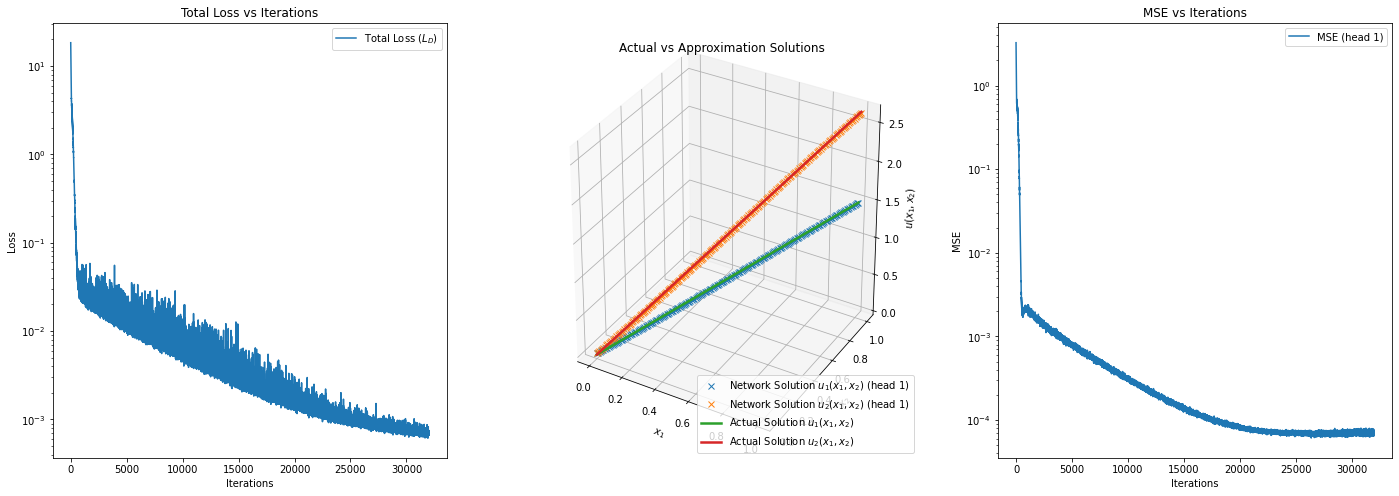

In [15]:
# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_funct, iterations=iterations, 
                           trained_model=trained_model, v_list=v_list, A_list=A_list, 
                           force=force, train_losses=loss_hist['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist, 
                           head_to_track=head_to_track)

### Step 4a: Perform One-Shot Transfer Learning (use an initial condition that was trained on)

tensor([ 0.0149, -0.0186, -0.0208, -0.0169, -0.0094], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.1169, -0.1163, -0.1119, -0.1123, -0.1122], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.0857, -0.1463, -0.1684, -0.1834, -0.1900], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 0.0198, -0.0095, -0.0087,  0.0133,  0.0342], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.1114, -0.0961, -0.0967, -0.1008, -0.1020], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.1263, 0.1578, 0.1791, 0.1922, 0.1997], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 0.0140, -0.0513, -0.0973, -0.1122, -0.1227], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.0562, -0.0628, -0.0418, -0.0273, -0.0148], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.0228, 0.0098, 0.0056, 0.0115, 0.0193], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.1324, 0.1432, 0.1448, 0.1389, 0.1356], device='cuda:0',

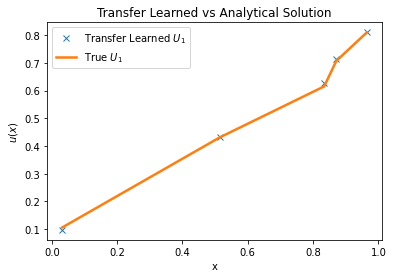

In [25]:
# pick a G that has been trained on
G = G_list[0]

# compute H, S, and H_0
H, S, H_0, x, x_0 = compute_H_and_S(x_range[0], x_range[1], G, trained_model, num_equations, hid_lay)

# print(S.shape)
# print(S)
# print("-" * 25)

# pick an initial condition and A matrix from those that were trained on (easy case)
v = v_list[0]
A = A_list[0]

# print(S)
#################################################################
# create S original way for 1 equation...
_, H_orig = trained_model(x)
print(H_orig.shape)
dH_dx = [torch.autograd.grad(H_orig[:, i], x, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
dH_dx = torch.hstack(dH_dx)
print("dH)dx shape: ", dH_dx.shape)
H_x1 = dH_dx[:, 0:256] # 0:hid_lay[-1]
# H_x1 = dH_dx[:, range(0, 512, 2)]
H_x1 = H_x1.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x1 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x1), 2)
H_x2 = dH_dx[:, 256:]
# H_x2 = dH_dx[:, range(1, 512, 2)]
H_x2 = H_x2.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x2 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x2), 2)
S = H_x1 - 1 * H_x2
print(S.shape)
# print(S)
print("-" * 25)
################################################################

################################################################
# create S original way for 2 equations...
# _, H_orig = trained_model(x)
# print(H_orig.shape)
# dH_dx = [torch.autograd.grad(H_orig[:, i], x, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
# dH_dx = torch.hstack(dH_dx)
# print("dH_dx shape: ", dH_dx.shape) # [512, 256]
# # you have as many H_xis as independent variables??
# H_x1 = dH_dx[:, 0:256] 
# # H_x1 = dH_dx[:, range(0, 1024, 2)]
# H_x1 = H_x1.reshape(-1, num_equations, hid_lay[-1] // num_equations)
# H_x1 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x1), 2)
# H_x2 = dH_dx[:, 256:]
# # H_x2 = dH_dx[:, range(1, 1024, 2)]
# H_x2 = H_x2.reshape(-1, num_equations, hid_lay[-1] // num_equations)
# H_x2 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x2), 2)
# print(H_x1.shape)
# print(H_x2.shape)
# S = torch.mul(G[0:1].T, H_x1) + torch.mul(G[1:2].T, H_x2)
# # S = torch.mul(G[:, 0:1], H_x1) + torch.mul(G[:, 1:2], H_x2)
# print(S.shape)
# print("-" * 25)

# S needs to be of shape ([512, 2, 65])
################################################################

# compute and plot the transfer learned solution
M_inv, W_out, force_terms = analytically_compute_weights(H, H_0, S, x, x_0, v, A, force)
plot_transfer_learned_and_analytical(H, W_out, x, v, A, force, num_equations, true_funct)


# tensor([ 0.0010, -0.0171, -0.0232, -0.0174, -0.0161], device='cuda:0',

In [26]:
H_x1

tensor([ 0.0010, -0.0171, -0.0232, -0.0174, -0.0161], device='cuda:0',

tensor([[[ 0.0000,  0.0149, -0.0495,  ..., -0.0054, -0.1272, -0.1932]],

        [[ 0.0000, -0.0186, -0.0929,  ...,  0.0740, -0.0832, -0.1400]],

        [[ 0.0000, -0.0208, -0.0960,  ...,  0.0951, -0.0484, -0.0922]],

        [[ 0.0000, -0.0169, -0.0846,  ...,  0.0967, -0.0289, -0.0607]],

        [[ 0.0000, -0.0094, -0.0696,  ...,  0.0942, -0.0117, -0.0351]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
print(dH_dx)
print(dH_dx.shape)

tensor([[ 0.0162,  0.2446, -0.0060,  ...,  0.1547,  0.0400,  0.3026],
        [ 0.0161,  0.2445, -0.0059,  ...,  0.1547,  0.0401,  0.3027],
        [ 0.0157,  0.2441, -0.0057,  ...,  0.1547,  0.0401,  0.3031],
        ...,
        [-0.1282,  0.0338,  0.2055,  ...,  0.1547,  0.1007,  0.4181],
        [-0.1279,  0.0339,  0.2065,  ...,  0.1547,  0.1005,  0.4179],
        [-0.1278,  0.0340,  0.2072,  ...,  0.1548,  0.1004,  0.4177]],
       device='cuda:0', grad_fn=<CatBackward0>)
torch.Size([512, 512])


In [ ]:
# TODO:
# 1.) run with 60,000 epochs to see how it works...
# 2.) code up the generalized S this new way...
# 3.) clean up the code
# 4.) train with varying G and initial conditions
# 5.) try transfer learning...

S shape before reshaping: torch.Size([2, 128, 512])
Time to compute H and dH_dt:  0.208 seconds
torch.Size([512, 256])
dH_dx:  torch.Size([512, 512])
tensor(9.2651e+11, device='cuda:0', grad_fn=<SqueezeBackward1>)
torch.Size([512, 2, 129])
torch.Size([512, 2, 129])
torch.Size([512, 2, 129])
-------------------------
Condition Number:  tensor(5.1852e+10, device='cuda:0', grad_fn=<SqueezeBackward1>)
torch.Size([512, 2, 1])
torch.Size([512, 2, 129])
torch.Size([512, 129, 1])
torch.Size([129, 1])
H_0_T_times_u_0 shape:  torch.Size([129, 1])
force terms:  torch.Size([129, 1])
1.0907824


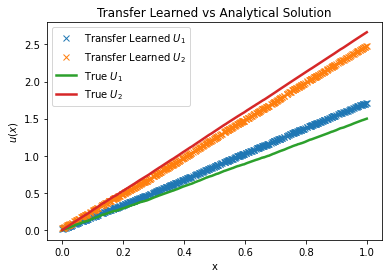

In [56]:
# pick a G that has been trained on
G = G_list[0]

# compute H, S, and H_0
H, S, H_0, x, x_0 = compute_H_and_S(x_range[0], x_range[1], G, trained_model, num_equations, hid_lay)

# print(S.shape)
# print(S)
# print("-" * 25)

# pick an initial condition and A matrix from those that were trained on (easy case)
v = v_list[0]
A = A_list[0]

# ################################################################
# create S original way for 1 equation...
_, H_orig = trained_model(x)
print(H_orig.shape)
dH_dx = [torch.autograd.grad(H_orig[:, i], x, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
dH_dx = torch.hstack(dH_dx)
print(dH_dx.shape)
H_x1 = dH_dx[:, 0:256] # 0:hid_lay[-1]
H_x1 = H_x1.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x1 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x1), 2)

H_x2 = dH_dx[:, 256:]
H_x2 = H_x2.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x2 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x2), 2)

S = H_x1 - 1 * H_x2

# print(S.shape)
# print(S)
# print("-" * 25)
# ################################################################

################################################################
# create S original way for 2 equations...
_, H_orig = trained_model(x)
print(H_orig.shape)
dH_dx = [torch.autograd.grad(H_orig[:, i], x, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
dH_dx = torch.hstack(dH_dx)
print("dH_dx: ", dH_dx.shape) # [512, 256]
print(torch.linalg.cond(dH_dx))
# you have as many H_xis as independent variables??
H_x1 = dH_dx[:, 0:256] 
H_x1 = H_x1.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x1 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x1), 2)
H_x2 = dH_dx[:, 256:]
H_x2 = H_x2.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_x2 = torch.cat((torch.zeros(len(x), num_equations, 1, device=dev), H_x2), 2)
print(H_x1.shape)
print(H_x2.shape)
# S = torch.mul(G[0:1].T, H_x1) + torch.mul(G[1:2].T, H_x2)
S = torch.mul(G[:, 0:1], H_x1) + torch.mul(G[:, 1:2], H_x2)
print(S.shape)
print("-" * 25)

# S needs to be of shape ([512, 2, 65])
################################################################


# compute and plot the transfer learned solution
M_inv, W_out, force_terms = analytically_compute_weights(H, H_0, S, x, x_0, v, A, force)
plot_transfer_learned_and_analytical(H, W_out, x, v, A, force, num_equations, true_funct)

In [ ]:
print(G)
print(G[0:1].T.shape)
print(G[:, 0:1].shape)

tensor([[1., 4.],
        [1., 9.]], device='cuda:0')
torch.Size([2, 1])
torch.Size([2, 1])


In [ ]:
# torch.mul(G[0:1].T, torch.ones((10, 2, 15), device=dev))

### Step 4b: Perform One-Shot Transfer Learning (use a new, unseen initial condition)

<ipython-input-26-ee4e683835b2>:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  W_out_transfer = torch.matmul(M_inv, force_terms + (torch.matmul(H_0.T, v_eval_transfer).reshape(H.shape[-1], H.shape[1])) / len(x))


0.2308059


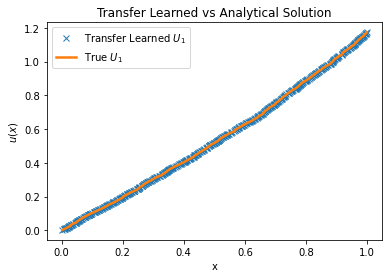

In [ ]:
# choose new initial condition that has not been trained on (harder case)
v_transfer = lambda x: torch.sinh(x[:, 0:1])
# v_transfer = lambda x: torch.cat((2 * x[:, 0:1], 3 * x[:, 0:1]), dim=1)

v_eval_transfer = v_transfer(x_0)

# compute and plot the transfer learned solution
W_out_transfer = torch.matmul(M_inv, force_terms + (torch.matmul(H_0.T, v_eval_transfer).reshape(H.shape[-1], H.shape[1])) / len(x))
plot_transfer_learned_and_analytical(H, W_out_transfer, x, v_transfer, A, force, num_equations, true_funct)

### Step 4c: Perform One-Shot Transfer Learning (use a new diff eq. and an initial condition that was trained on)

torch.Size([512, 1, 1])
torch.Size([512, 1, 257])
torch.Size([512, 257, 1])
torch.Size([257, 1])
0.1258672


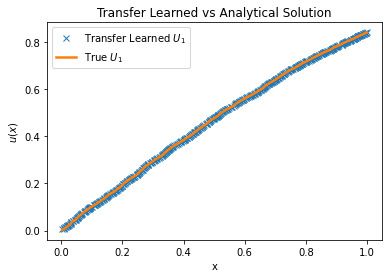

In [ ]:
# new differential equation to apply training to
transfer_A = torch.tensor([[-0.34]], device=dev)

# compute and plot the transfer learned solution
M_inv_new, W_out_new, force_terms_new = analytically_compute_weights(H, H_0, S, x, x_0, v, transfer_A, force)
plot_transfer_learned_and_analytical(H, W_out_new, x, v, transfer_A, force, num_equations, true_funct)

### Step 4d: Perform One-Shot Transfer Learning (use a new diff eq. and an unseen initial condition)

torch.Size([512, 1, 1])
torch.Size([512, 1, 257])
torch.Size([512, 257, 1])
torch.Size([257, 1])
0.10197416


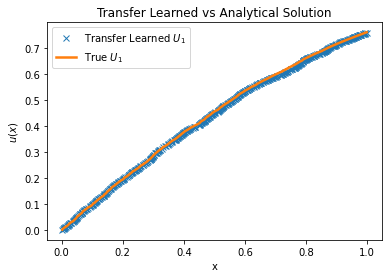

In [ ]:
# use both a new A and a new intital condition
transfer_A_new = torch.tensor([[-0.5]], device=dev)
v_transfer_new = lambda x: torch.tanh(x[:, 0:1])

# compute and plot the transfer learned solution
M_inv_new, W_out_new, force_terms_new = analytically_compute_weights(H, H_0, S, x, x_0, v_transfer_new, transfer_A_new, force)
plot_transfer_learned_and_analytical(H, W_out_new, x, v_transfer_new, transfer_A_new, force, num_equations, true_funct)

# CODE BELOW HERE IS NOT ADAPTED FOR PDEs yet...

# Appendix

Mean of residuals: 0.0007473001023754478
Initial Condition Residual: 1.7308775568380952e-07


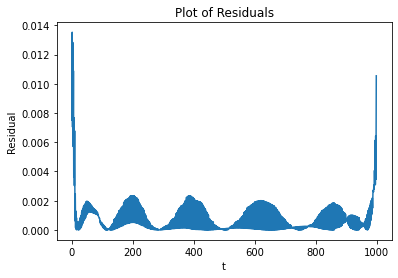

In [ ]:
# compute the residuals to determine effectiveness of transfer learning when changing initial condition
residuals = ((torch.matmul(dH_dt_new, W_out_transfer) + torch.matmul(A, torch.matmul(H, W_out_transfer)) - torch.stack([force] * len(t_eval))).squeeze()) ** 2
residuals = residuals.reshape(-1, 1).detach().cpu().numpy()

print(f"Mean of residuals: {residuals.mean()}")
initial_cond_residuals = ((torch.matmul(H_0, W_out_transfer) - v_transfer) ** 2).mean()
print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plot the residuals
plt.plot(residuals);
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Plot of Residuals");

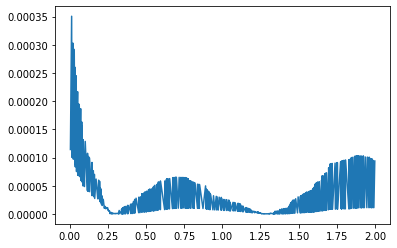

In [ ]:
plt.plot(t_eval.detach().cpu().numpy(), residuals[0:500])

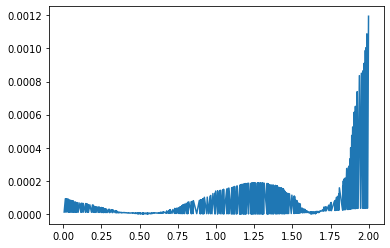

In [ ]:
plt.plot(t_eval.detach().cpu().numpy(), residuals[500:])

In [ ]:
# time One-Shot Transfer Learning

start_one_shot_time = time.time()

# compute weights for 10000 different initial conditions
for i in range(10000): 
    random_u_0 = torch.rand((num_equations, 1), device=dev)
    w_out = torch.matmul(M_inv, force_terms + torch.matmul(H_0.T, random_u_0))
    
end_one_shot_time = time.time() 
total_one_shot = end_one_shot_time - start_one_shot_time
print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

Total Time to evaluate w_out for 10000 different initial conditions:  0.55 seconds


In [ ]:
# QUESTIONS:

# Note: 
    # TODO: once list is created temp = [xx1, xx2, xx3..] pass into np.concatenate() like np.cat(*temp) to unpack so length of number of arguments can vary

########################################################################################################################

# TODOS:


# ONCE 2 EQUATION EXAMPLE WORKS, MAKE SURE ONE EQUATION EXAMPLE FROM BEFORE STILL WORKS... (with sin(x) boundary condition)

# 1. Create notes entry for Pavlos's PDE notes...

# 2. comment + add dostrings for all ODE and PDE code

# 3. create a config file for all the configuration info for both ODE and PDE

# 4. for ODE code, implement + train an example with a forcing function (f) that is not constant (functino of t)
     # and try transfer learning this way

# 5. for ODE code, implement A matrix that is a function of t and do transfer learning with it...

# 6. make transfer learning plot 3D for PDE code 

# 7. save 109a lecture slide from last semester

########################################################################################################################

# COMPLETED:


In [ ]:
# rng = np.random.default_rng()
# # every batch, randomly sample inputs from min and max range
# data = torch.arange(0, 2, 0.001, requires_grad=True, device=dev)

# x1 = data[rng.choice(range(0, len(data)), size=3, replace=False)] # TODO: change size back to 512
# x1, _ = x1.reshape(-1, 1).sort(dim=0)
# x2 = data[rng.choice(range(0, len(data)), size=3, replace=False)] # TODO: change size back to 512
# x2, _ = x2.reshape(-1, 1).sort(dim=0)
# x = torch.cat([x1, x2], dim=1)
# print(x)
# print(x.shape)
# print("result: ")
# print(true_single_pde_eq(x, A_single_eq_pde[0], v_list_one_eq_pde[0]))